# Outlier Detection with Auto-Encoders (AE) - CIFAR10 IMAGE DATASET

## METHOD:
 The Auto-Encoder (AE) outlier detector is first trained on a batch of unlabeled, but normal (inlier) data. Unsupervised training is desireable since labeled data is often scarce. The AE detector tries to reconstruct the input it receives. If the input data cannot be reconstructed well, the reconstruction error is high and the data can be flagged as an outlier. The reconstruction error is measured as the mean squared error (MSE) between the input and the reconstructed instance.

## DATASET: 
CIFAR10 consists of 60,000 32 by 32 RGB images equally distributed over 10 classes.

In [3]:
# Install alibi-detect
!pip install alibi-detect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 306 kB 4.2 MB/s 
     |████████████████████████████████| 5.5 MB 27.7 MB/s 
     |████████████████████████████████| 3.3 MB 41.4 MB/s 
     |████████████████████████████████| 34.5 MB 16 kB/s 
     |████████████████████████████████| 182 kB 58.3 MB/s 
     |████████████████████████████████| 7.6 MB 41.9 MB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.39.1
    Uninstalling llvmlite-0.39.1:
      Successfully uninstalled llvmlite-0.39.1
  Attempting uninstall: numba
    Found existing installation: numba 0.56.4
    Uninstalling numba-0.56.4:
      Successfully uninstalled numba-0.56.4


In [4]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, \
    Dense, Layer, Reshape, InputLayer, Flatten
from tqdm import tqdm

from alibi_detect.od import OutlierAE
from alibi_detect.utils.fetching import fetch_detector
from alibi_detect.utils.perturbation import apply_mask
from alibi_detect.saving import save_detector, load_detector
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image

logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Load CIFAR10 data

In [15]:
train, test = tf.keras.datasets.cifar10.load_data()
X_train, y_train = train
X_test, y_test = test

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


# Load or define outlier detector 
The pretrained outlier and adversarial detectors used in the example notebooks can be found here(https://console.cloud.google.com/storage/browser/seldon-models/alibi-detect;tab=objects?pli=1&prefix=&forceOnObjectsSortingFiltering=false) . You can use the built-in fetch_detector function which saves the pre-trained models in a local directory filepath and loads the detector. Alternatively, you can train a detector from scratch:

The following code will create folder called "my_path" and Outlier Detector Model - AE gets saved in h5 format.

In [16]:
load_outlier_detector = True


In [17]:
filepath = 'my_path'  # change to (absolute) directory where model is downloaded
detector_type = 'outlier'
dataset = 'cifar10'
detector_name = 'OutlierAE'
filepath = os.path.join(filepath, detector_name)
if load_outlier_detector:  # load pretrained outlier detector
    od = fetch_detector(filepath, detector_type, dataset, detector_name)
else:  # define model, initialize, train and save outlier detector
    encoding_dim = 1024

    encoder_net = tf.keras.Sequential(
      [
          InputLayer(input_shape=(32, 32, 3)),
          Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
          Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
          Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
          Flatten(),
          Dense(encoding_dim,)
      ])

    decoder_net = tf.keras.Sequential(
      [
          InputLayer(input_shape=(encoding_dim,)),
          Dense(4*4*128),
          Reshape(target_shape=(4, 4, 128)),
          Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
          Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
          Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
      ])

    # initialize outlier detector
    od = OutlierAE(threshold=.015,  # threshold for outlier score
                    encoder_net=encoder_net,  # can also pass AE model instead
                    decoder_net=decoder_net,  # of separate encoder and decoder
                    )
    # train
    od.fit(X_train,
           epochs=50,
           verbose=True)

    # save the trained outlier detector
    save_detector(od, filepath)

49850794/49850794 [==============================] - 3s 0us/step


/usr/local/lib/python3.7/dist-packages/alibi_detect/saving/tensorflow/_loading.py:222: UserWarning: Trying to load detector from an older version.This may lead to breaking code or invalid results.
  warnings.warn('Trying to load detector from an older version.'


# Check quality AE model

In [18]:
idx = 8
X = X_train[idx].reshape(1, 32, 32, 3)
X_recon = od.ae(X)

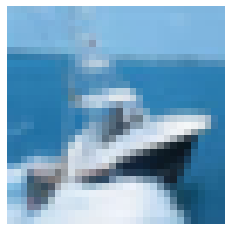

In [19]:
plt.imshow(X.reshape(32, 32, 3))
plt.axis('off')
plt.show()

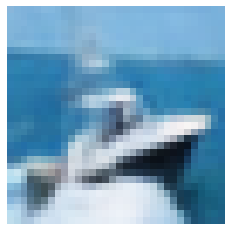

In [20]:
plt.imshow(X_recon.numpy().reshape(32, 32, 3))
plt.axis('off')
plt.show()

# Check outliers on original CIFAR images

In [21]:
X = X_train[:500]
print(X.shape)

(500, 32, 32, 3)


In [22]:
od_preds = od.predict(X,
                      outlier_type='instance',    # use 'feature' or 'instance' level
                      return_feature_score=True,  # scores used to determine outliers
                      return_instance_score=True)
print(list(od_preds['data'].keys()))

['instance_score', 'feature_score', 'is_outlier']


In [25]:
import pandas as pd

In [38]:
a = pd.DataFrame(od_preds['data'].values())

In [39]:
a.head(10)

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.000784,0.000844,0.000379,0.000409,0.00053,0.001094,0.001291,0.000609,0.000525,0.000279,...,0.00022,0.000209,0.000582,0.004716,0.000608,0.000578,0.000428,0.000283,0.000549,0.00044
1,"[[[0.0006458701, 0.0005257772, 0.0030391663], ...","[[[0.00020057755, 0.0070611765, 0.013315967], ...","[[[0.00018575991, 0.0001932211, 0.00026915292]...","[[[0.00024388715, 0.00014384864, 0.0004097777]...","[[[2.581111e-06, 0.00025775115, 2.6800313e-05]...","[[[0.0025953003, 0.0004383553, 0.00013447054],...","[[[0.0005248735, 0.0043339645, 0.0077716615], ...","[[[5.195501e-05, 1.0685983e-05, 0.0007959041],...","[[[0.00014881087, 0.00015558135, 0.0002671676]...","[[[0.00032401632, 7.549116e-06, 1.2010424e-06]...",...,"[[[8.219155e-05, 7.6840064e-05, 1.3531806e-05]...","[[[0.0001501072, 0.00016181859, 0.00024301595]...","[[[0.00012591065, 1.0390313e-06, 0.00042336687...","[[[0.018858168, 0.012833223, 0.00830556], [0.0...","[[[1.2672534e-05, 0.00011961466, 0.0002156625]...","[[[3.4187142e-05, 6.591892e-05, 0.00013840408]...","[[[2.6468095e-05, 3.184087e-05, 4.311455e-05],...","[[[1.9152456e-05, 0.00019991123, 3.4970846e-05...","[[[0.0046477844, 0.00016040006, 0.0028991671],...","[[[2.1758196e-06, 0.0007505715, 0.0017105477],..."
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Plot instance level outlier scores

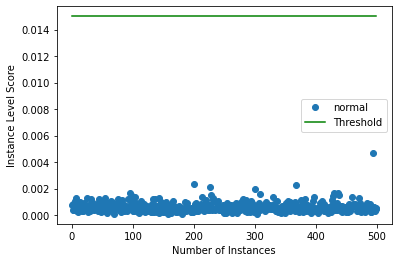

In [40]:
target = np.zeros(X.shape[0],).astype(int)  # all normal CIFAR10 training instances
labels = ['normal', 'outlier']
plot_instance_score(od_preds, target, labels, od.threshold)

# Visualize predictions


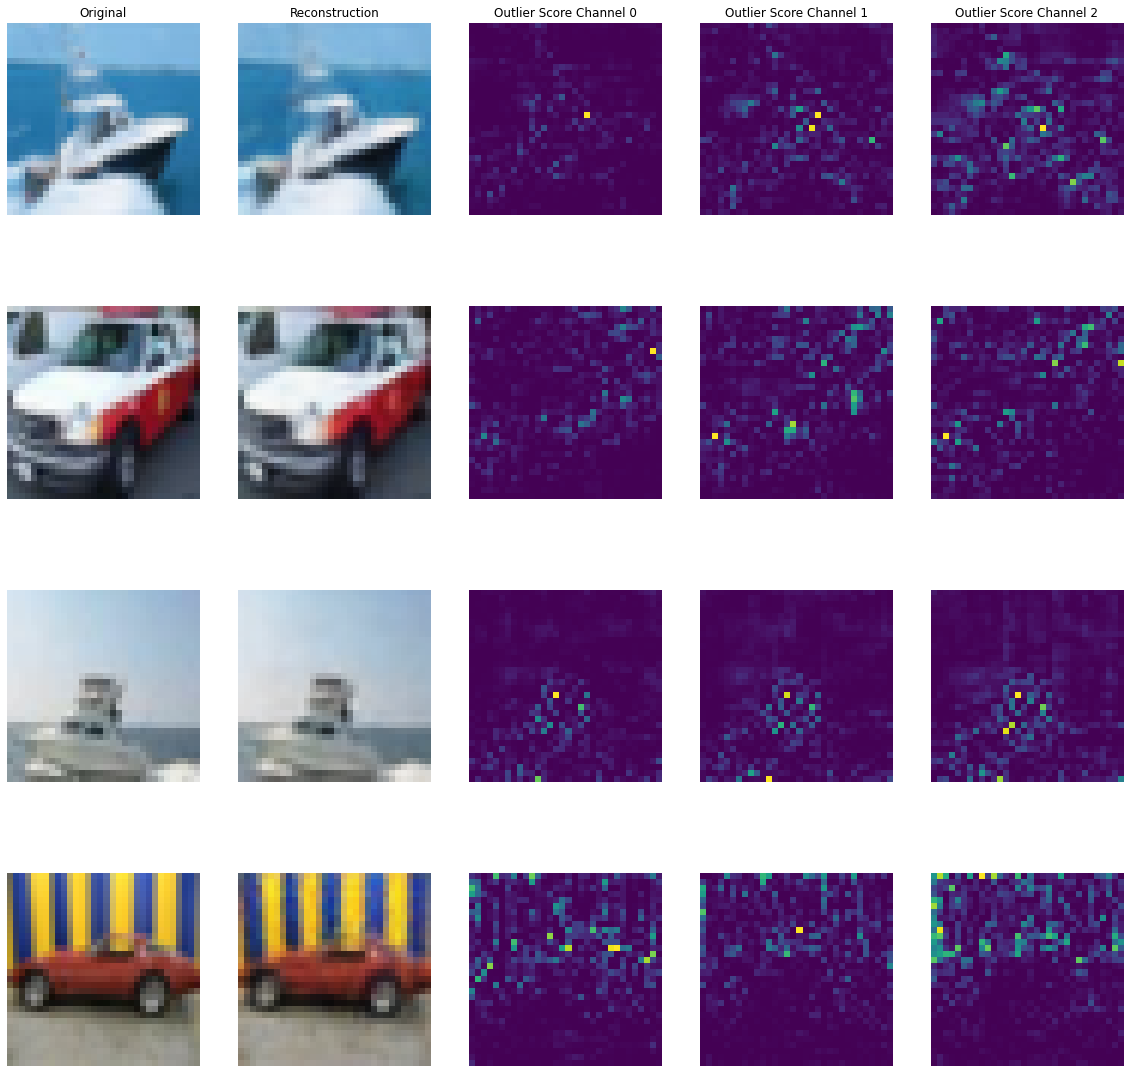

In [41]:
X_recon = od.ae(X).numpy()
plot_feature_outlier_image(od_preds,
                           X,
                           X_recon=X_recon,
                           instance_ids=[8, 60, 100, 330],  # pass a list with indices of instances to display
                           max_instances=5,  # max nb of instances to display
                           outliers_only=False)  # only show outlier predictions